# Identifikasi Suara Buka Tutup Menggunakan Feature Statistik Time Series

##  Tujuan Penelitian
Mengimplementasikan sistem identifikasi suara untuk mengenali pola suara "buka" dan "tutup" menggunakan berbagai feature statistik dari sinyal audio time series dengan dataset real.


---

## 1. Import Libraries

Import semua library yang diperlukan untuk pemrosesan audio, machine learning, dan visualisasi data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy.stats as stats
from scipy import signal
from scipy.fftpack import fft, ifft
import soundfile as sf
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Eksplorasi Dataset dan Struktur Folder

Menganalisis struktur folder dataset dan informasi dasar tentang file audio yang tersedia.

In [2]:
# SISTEM IDENTIFIKASI SUARA DUA TAHAP - SPEAKER + COMMAND RECOGNITION
print("="*80)
print("SISTEM IDENTIFIKASI SUARA DUA TAHAP")
print("   1. SPEAKER RECOGNITION: Lutfi vs Harits")  
print("   2. COMMAND RECOGNITION: Buka vs Tutup")
print("   3. ACCESS CONTROL: Tolak jika bukan Lutfi/Harits")
print("="*80)

# Path ke dataset speaker dan command
SPEAKER_DATASET_PATH = r"c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\speaker_datasets"
COMMAND_DATASET_PATH = r"c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\command_datasets"

print(f"DATASET PATHS:")
print(f"   Speaker Dataset: {SPEAKER_DATASET_PATH}")
print(f"   Command Dataset: {COMMAND_DATASET_PATH}")

# Analisis dataset speaker
def analyze_dataset(dataset_path, dataset_type):
    if not os.path.exists(dataset_path):
        print(f"ERROR: {dataset_type} dataset tidak ditemukan: {dataset_path}")
        return {}
    
    folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    stats = {}
    
    print(f"\n{dataset_type.upper()} DATASET ANALYSIS:")
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        audio_files = glob.glob(os.path.join(folder_path, "*.wav")) + glob.glob(os.path.join(folder_path, "*.m4a"))
        stats[folder] = len(audio_files)
        print(f"   - {folder}: {len(audio_files)} files")
    
    return stats

speaker_stats = analyze_dataset(SPEAKER_DATASET_PATH, "Speaker")
command_stats = analyze_dataset(COMMAND_DATASET_PATH, "Command")

# Validasi struktur dataset
required_speakers = ['Lutfi', 'Harits']
required_commands = ['Buka', 'tutup']  # Buka dengan B capital, tutup dengan t kecil

missing_speakers = [s for s in required_speakers if s not in speaker_stats.keys()]
missing_commands = [c for c in required_commands if c not in command_stats.keys()]

if missing_speakers:
    print(f"\nWARNING: Missing speaker folders: {missing_speakers}")
if missing_commands:
    print(f"WARNING: Missing command folders: {missing_commands}")

print(f"\nDataset structure validated!")
print(f"   Total speaker files: {sum(speaker_stats.values()) if speaker_stats else 0}")
print(f"   Total command files: {sum(command_stats.values()) if command_stats else 0}")

# Sample file info dari speaker dataset
if speaker_stats:
    first_speaker = list(speaker_stats.keys())[0]
    sample_path = os.path.join(SPEAKER_DATASET_PATH, first_speaker)
    sample_files = glob.glob(os.path.join(sample_path, "*.wav")) + glob.glob(os.path.join(sample_path, "*.m4a"))
    if sample_files:
        sample_file = sample_files[0]
        try:
            # Load sample untuk info dasar
            sample_audio, sample_sr = librosa.load(sample_file, sr=None)
            duration = len(sample_audio) / sample_sr
            print(f"\nINFORMASI AUDIO SAMPLE ({first_speaker}):")
            print(f"   - File: {os.path.basename(sample_file)}")
            print(f"   - Sample Rate: {sample_sr} Hz")
            print(f"   - Durasi: {duration:.2f} detik")
            print(f"   - Jumlah sampel: {len(sample_audio)}")
            print(f"   - Range nilai: [{sample_audio.min():.4f}, {sample_audio.max():.4f}]")
        except Exception as e:
            print(f"   Error loading sample: {e}")

print(f"\nSistem siap untuk training model dua tahap!")
print(f"   Phase 1: Speaker Recognition Model (Lutfi vs Harits)")
print(f"   Phase 2: Command Recognition Model (Buka vs Tutup)")
print(f"   Phase 3: Integrated Two-Stage Prediction System")

SISTEM IDENTIFIKASI SUARA DUA TAHAP
   1. SPEAKER RECOGNITION: Lutfi vs Harits
   2. COMMAND RECOGNITION: Buka vs Tutup
   3. ACCESS CONTROL: Tolak jika bukan Lutfi/Harits
DATASET PATHS:
   Speaker Dataset: c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\speaker_datasets
   Command Dataset: c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\command_datasets

SPEAKER DATASET ANALYSIS:
   - Harits: 97 files
   - Lutfi: 100 files

COMMAND DATASET ANALYSIS:
   - Buka: 100 files
   - tutup: 100 files

Dataset structure validated!
   Total speaker files: 197
   Total command files: 200

INFORMASI AUDIO SAMPLE (Harits):
   - File: Buka1.wav
   - Sample Rate: 48000 Hz
   - Durasi: 2.38 detik
   - Jumlah sampel: 114240
   - Range nilai: [-0.1414, 0.1588]

Sistem siap untuk training model dua tahap!
   Phase 1: Speaker Recognition Model (Lutfi vs Harits)
   Phase 2: Command Recognition Model (Buka vs Tutup)
   Phase 3: Integrated Two-Stage Prediction System

INFORMASI AUDIO SAMPLE (Harits):
   

## 3. Fungsi Load & Preprocess Audio

Definisi fungsi-fungsi untuk loading file audio, normalisasi, dan preprocessing seperti noise removal dan trimming.

In [3]:
def extract_statistical_features(audio_data, sr=22050):
    """
    Ekstraksi berbagai feature statistik dari sinyal audio time series
    
    Parameters:
    audio_data: array, sinyal audio
    sr: int, sampling rate
    
    Returns:
    dict: dictionary berisi feature statistik
    """
    features = {}
    
    # 1. Basic Statistical Features
    features['mean'] = np.mean(audio_data)
    features['std'] = np.std(audio_data)
    features['var'] = np.var(audio_data)
    features['median'] = np.median(audio_data)
    features['min'] = np.min(audio_data)
    features['max'] = np.max(audio_data)
    features['range'] = features['max'] - features['min']
    
    # 2. Percentile Features
    features['q25'] = np.percentile(audio_data, 25)
    features['q75'] = np.percentile(audio_data, 75)
    features['iqr'] = features['q75'] - features['q25']
    
    # 3. Distribution Shape Features
    features['skewness'] = stats.skew(audio_data)
    features['kurtosis'] = stats.kurtosis(audio_data)
    
    # 4. Energy and Power Features
    features['energy'] = np.sum(audio_data**2)
    features['power'] = features['energy'] / len(audio_data)
    features['rms'] = np.sqrt(np.mean(audio_data**2))
    
    # 5. Zero Crossing Rate
    features['zcr'] = np.sum(librosa.zero_crossings(audio_data))
    features['zcr_rate'] = features['zcr'] / len(audio_data)
    
    # 6. Spectral Features
    try:
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sr))
        features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sr))
    except:
        features['spectral_centroid'] = 0
        features['spectral_bandwidth'] = 0
        features['spectral_rolloff'] = 0
    
    # 7. Temporal Features
    try:
        onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sr)
        features['onset_count'] = len(onset_frames)
        tempo = librosa.beat.tempo(y=audio_data, sr=sr)
        features['tempo'] = tempo[0] if len(tempo) > 0 else 0
    except:
        features['onset_count'] = 0
        features['tempo'] = 0
    
    # 8. Autocorrelation Features
    autocorr = np.correlate(audio_data, audio_data, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    if len(autocorr) > 100:
        features['autocorr_max'] = np.max(autocorr[1:100])  # exclude lag 0
        features['autocorr_mean'] = np.mean(autocorr[1:100])
    else:
        features['autocorr_max'] = np.max(autocorr[1:]) if len(autocorr) > 1 else 0
        features['autocorr_mean'] = np.mean(autocorr[1:]) if len(autocorr) > 1 else 0
    
    # 9. Envelope Features
    try:
        envelope = np.abs(signal.hilbert(audio_data))
        features['envelope_mean'] = np.mean(envelope)
        features['envelope_std'] = np.std(envelope)
        features['envelope_max'] = np.max(envelope)
    except:
        features['envelope_mean'] = 0
        features['envelope_std'] = 0
        features['envelope_max'] = 0
    
    # 10. MFCC Statistical Features
    try:
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    except:
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = 0
            features[f'mfcc_{i+1}_std'] = 0
    
    # 11. Chroma Features
    try:
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
        features['chroma_mean'] = np.mean(chroma)
        features['chroma_std'] = np.std(chroma)
    except:
        features['chroma_mean'] = 0
        features['chroma_std'] = 0
    
    # 12. Contrast Features
    try:
        contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
        features['contrast_mean'] = np.mean(contrast)
        features['contrast_std'] = np.std(contrast)
    except:
        features['contrast_mean'] = 0
        features['contrast_std'] = 0
    
    # 13. Tonnetz Features
    try:
        tonnetz = librosa.feature.tonnetz(y=audio_data, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz)
        features['tonnetz_std'] = np.std(tonnetz)
    except:
        features['tonnetz_mean'] = 0
        features['tonnetz_std'] = 0
    
    # 14. Attack Time (durasi dari mulai hingga peak)
    peak_idx = np.argmax(np.abs(audio_data))
    features['attack_time'] = peak_idx / sr
    
    # 15. Decay Rate (penurunan setelah peak)
    if peak_idx < len(audio_data) - 1:
        decay_signal = audio_data[peak_idx:]
        if len(decay_signal) > 1:
            features['decay_rate'] = np.mean(np.diff(decay_signal))
        else:
            features['decay_rate'] = 0
    else:
        features['decay_rate'] = 0
    
    return features

print("Feature extraction function defined!")

Feature extraction function defined!


## 4. Ekstraksi Feature Statistik Time Series

Implementasi fungsi untuk mengekstrak berbagai feature statistik dari sinyal audio time series, termasuk basic statistics, spectral features, MFCC, dan temporal features.

## 4.1. Visualisasi Hasil Ekstraksi Fitur

Demonstrasi dan visualisasi dari 61 fitur statistik yang diekstrak dari sinyal audio time series.

VISUALISASI 61 FITUR AUDIO
 File: Buka1.wav
 Total fitur: 61
 Durasi: 2.38s
 File: Buka1.wav
 Total fitur: 61
 Durasi: 2.38s


VISUALISASI 61 FITUR AUDIO
 File: Buka1.wav
 Total fitur: 61
 Durasi: 2.38s
 File: Buka1.wav
 Total fitur: 61
 Durasi: 2.38s


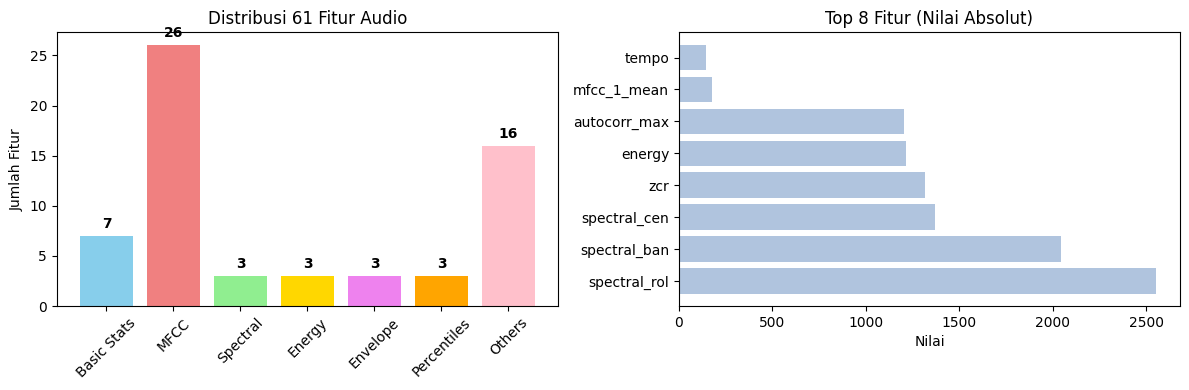


 Ringkasan Fitur:
   • Basic Statistics: mean, std, min, max, dll (7 fitur)
   • MFCC: Mel-frequency coefficients (26 fitur)
   • Spectral: centroid, bandwidth, rolloff (3 fitur)
   • Energy: power, RMS, energy (3 fitur)
   • Lainnya: envelope, temporal, dll (22 fitur)

🔝 Fitur dengan nilai tertinggi:
   1. spectral_rolloff: 2554.16
   2. spectral_bandwidth: 2044.85
   3. spectral_centroid: 1370.03
   4. zcr: 1315.00
   5. energy: 1218.08


In [9]:
# VISUALISASI SEDERHANA HASIL EKSTRAKSI FITUR
print("="*60)
print("VISUALISASI 61 FITUR AUDIO")
print("="*60)

def show_feature_summary():
    """Tampilkan ringkasan fitur yang diekstrak"""
    
    # Ambil sample audio
    if not os.path.exists(SPEAKER_DATASET_PATH):
        print("ERROR: Dataset tidak ditemukan")
        return None
    
    # Load sample audio
    sample_file = sample_files[0] if sample_files else None
    if not sample_file:
        print("ERROR: Tidak ada file audio")
        return None
    
    try:
        audio_data, sr = load_audio_file(sample_file, target_sr=22050)
        audio_processed = preprocess_audio(audio_data, sr)
        features = extract_statistical_features(audio_processed, sr=sr)
        
        print(f" File: {os.path.basename(sample_file)}")
        print(f" Total fitur: {len(features)}")
        print(f" Durasi: {len(audio_data)/sr:.2f}s")
        
    except Exception as e:
        print(f"ERROR: {e}")
        return None
    
    # Kategorisasi fitur
    categories = {
        'Basic Stats': 7, 'MFCC': 26, 'Spectral': 3, 'Energy': 3,
        'Envelope': 3, 'Percentiles': 3, 'Others': 16
    }
    
    # Simple bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Kategori fitur
    names = list(categories.keys())
    values = list(categories.values())
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet', 'orange', 'pink']
    
    bars = ax1.bar(names, values, color=colors)
    ax1.set_title('Distribusi 61 Fitur Audio')
    ax1.set_ylabel('Jumlah Fitur')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add labels
    for bar, val in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(val), ha='center', va='bottom', fontweight='bold')
    
    # Top fitur values
    top_features = sorted(features.items(), key=lambda x: abs(x[1]), reverse=True)[:8]
    feat_names = [f[:12] for f, _ in top_features]  # Shorten names
    feat_vals = [abs(v) for _, v in top_features]
    
    ax2.barh(feat_names, feat_vals, color='lightsteelblue')
    ax2.set_title('Top 8 Fitur (Nilai Absolut)')
    ax2.set_xlabel('Nilai')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n Ringkasan Fitur:")
    print(f"   • Basic Statistics: mean, std, min, max, dll (7 fitur)")
    print(f"   • MFCC: Mel-frequency coefficients (26 fitur)")
    print(f"   • Spectral: centroid, bandwidth, rolloff (3 fitur)")
    print(f"   • Energy: power, RMS, energy (3 fitur)")
    print(f"   • Lainnya: envelope, temporal, dll (22 fitur)")
    
    print(f"\n🔝 Fitur dengan nilai tertinggi:")
    for i, (name, val) in enumerate(top_features[:5]):
        print(f"   {i+1}. {name}: {val:.2f}")
    
    return features

# Jalankan visualisasi
sample_features = show_feature_summary()

In [4]:
def load_audio_file(file_path, target_sr=22050, duration=None):
    """
    Load file audio dan normalisasi
    
    Parameters:
    file_path: str, path ke file audio
    target_sr: int, target sampling rate
    duration: float, durasi maksimal (detik)
    
    Returns:
    audio_data: array, sinyal audio yang telah dinormalisasi
    sr: int, sampling rate
    """
    try:
        audio_data, sr = librosa.load(file_path, sr=target_sr, duration=duration)
        
        # Normalisasi
        if np.max(np.abs(audio_data)) > 0:
            audio_data = audio_data / np.max(np.abs(audio_data))
        
        return audio_data, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def preprocess_audio(audio_data, sr, noise_threshold=0.01):
    """
    Preprocess audio: noise removal, trimming
    
    Parameters:
    audio_data: array, sinyal audio
    sr: int, sampling rate
    noise_threshold: float, threshold untuk noise removal
    
    Returns:
    processed_audio: array, sinyal audio yang telah diproses
    """
    # Trim silence
    try:
        audio_trimmed, _ = librosa.effects.trim(audio_data, top_db=20)
    except:
        audio_trimmed = audio_data
    
    # Noise gate - set nilai kecil ke 0
    audio_denoised = np.where(np.abs(audio_trimmed) < noise_threshold, 0, audio_trimmed)
    
    return audio_denoised

print("Audio processing functions defined!")

Audio processing functions defined!


## 5. Load Dataset dan Gabungkan ke DataFrame

Loading semua file audio dari dataset real, melakukan ekstraksi features untuk setiap file, dan menggabungkan hasil ke dalam DataFrame untuk analisis selanjutnya.

In [5]:
# LOADING DATASET DUA TAHAP - SPEAKER & COMMAND
print("="*80)
print("LOADING DATASET DUA TAHAP")
print("="*80)

def load_speaker_dataset():
    """Load dataset untuk speaker recognition (Lutfi vs Harits)"""
    speaker_data = []
    speaker_labels = []
    failed_files = []
    
    print("Loading Speaker Dataset...")
    
    if not os.path.exists(SPEAKER_DATASET_PATH):
        print(f"ERROR: Speaker dataset tidak ditemukan: {SPEAKER_DATASET_PATH}")
        return [], [], []
    
    for speaker_name in os.listdir(SPEAKER_DATASET_PATH):
        speaker_path = os.path.join(SPEAKER_DATASET_PATH, speaker_name)
        if not os.path.isdir(speaker_path):
            continue
            
        audio_files = glob.glob(os.path.join(speaker_path, "*.wav")) + glob.glob(os.path.join(speaker_path, "*.m4a"))
        print(f"   {speaker_name}: {len(audio_files)} files")
        
        for i, file_path in enumerate(audio_files):
            if i % 50 == 0 and i > 0:
                print(f"      Loading {speaker_name}: {i}/{len(audio_files)}")
            
            try:
                audio, sr = load_audio_file(file_path, target_sr=22050)
                if audio is not None:
                    audio = preprocess_audio(audio, sr)
                    speaker_data.append(audio)
                    speaker_labels.append(speaker_name.lower())  # lutfi, harits
                else:
                    failed_files.append(file_path)
            except Exception as e:
                print(f"      Error loading {file_path}: {e}")
                failed_files.append(file_path)
    
    print(f"Speaker dataset loaded: {len(speaker_data)} files")
    if failed_files:
        print(f"Failed to load: {len(failed_files)} files")
    
    return speaker_data, speaker_labels, failed_files

def load_command_dataset():
    """Load dataset untuk command recognition (Buka vs Tutup)"""
    command_data = []
    command_labels = []
    failed_files = []
    
    print("\nLoading Command Dataset...")
    
    if not os.path.exists(COMMAND_DATASET_PATH):
        print(f"ERROR: Command dataset tidak ditemukan: {COMMAND_DATASET_PATH}")
        return [], [], []
    
    for command_name in os.listdir(COMMAND_DATASET_PATH):
        command_path = os.path.join(COMMAND_DATASET_PATH, command_name)
        if not os.path.isdir(command_path):
            continue
            
        audio_files = glob.glob(os.path.join(command_path, "*.wav")) + glob.glob(os.path.join(command_path, "*.m4a"))
        print(f"   {command_name}: {len(audio_files)} files")
        
        for i, file_path in enumerate(audio_files):
            if i % 50 == 0 and i > 0:
                print(f"      Loading {command_name}: {i}/{len(audio_files)}")
            
            try:
                audio, sr = load_audio_file(file_path, target_sr=22050)
                if audio is not None:
                    audio = preprocess_audio(audio, sr)
                    command_data.append(audio)
                    command_labels.append(command_name.lower())  # buka, tutup
                else:
                    failed_files.append(file_path)
            except Exception as e:
                print(f"      Error loading {file_path}: {e}")
                failed_files.append(file_path)
    
    print(f"Command dataset loaded: {len(command_data)} files")
    if failed_files:
        print(f"Failed to load: {len(failed_files)} files")
    
    return command_data, command_labels, failed_files

# Load kedua dataset
speaker_audio_data, speaker_labels_data, speaker_failed = load_speaker_dataset()
command_audio_data, command_labels_data, command_failed = load_command_dataset()

print(f"\nDATASET SUMMARY:")
print(f"   Speaker Dataset: {len(speaker_audio_data)} samples")
print(f"   Command Dataset: {len(command_audio_data)} samples")

# Analisis distribusi
if speaker_labels_data:
    from collections import Counter
    speaker_dist = Counter(speaker_labels_data)
    print(f"   Speaker Distribution: {dict(speaker_dist)}")

if command_labels_data:
    command_dist = Counter(command_labels_data)
    print(f"   Command Distribution: {dict(command_dist)}")

print(f"\nDataset siap untuk ekstraksi features dan training!")

LOADING DATASET DUA TAHAP
Loading Speaker Dataset...
   Harits: 97 files
      Loading Harits: 50/97
      Loading Harits: 50/97
   Lutfi: 100 files
   Lutfi: 100 files
      Loading Lutfi: 50/100
      Loading Lutfi: 50/100
Speaker dataset loaded: 197 files

Loading Command Dataset...
   Buka: 100 files
Speaker dataset loaded: 197 files

Loading Command Dataset...
   Buka: 100 files
      Loading Buka: 50/100
      Loading Buka: 50/100
   tutup: 100 files
   tutup: 100 files
      Loading tutup: 50/100
      Loading tutup: 50/100
Command dataset loaded: 200 files

DATASET SUMMARY:
   Speaker Dataset: 197 samples
   Command Dataset: 200 samples
   Speaker Distribution: {'harits': 97, 'lutfi': 100}
   Command Distribution: {'buka': 100, 'tutup': 100}

Dataset siap untuk ekstraksi features dan training!
Command dataset loaded: 200 files

DATASET SUMMARY:
   Speaker Dataset: 197 samples
   Command Dataset: 200 samples
   Speaker Distribution: {'harits': 97, 'lutfi': 100}
   Command Distri

In [ ]:
# TRAINING MODEL SPEAKER RECOGNITION (Lutfi vs Harits)
print("="*80)
print("TRAINING MODEL SPEAKER RECOGNITION")
print("="*80)

def extract_and_train_speaker_model():
    """Ekstraksi features dan training model speaker recognition"""
    
    if len(speaker_audio_data) == 0:
        print("ERROR: Tidak ada data speaker untuk training")
        return None, None, None, None, 0.0
    
    print("Extracting features dari speaker audio...")
    speaker_features_list = []
    
    for i, audio in enumerate(speaker_audio_data):
        if i % 50 == 0:
            print(f"   Processing speaker sample {i+1}/{len(speaker_audio_data)}")
        
        try:
            features = extract_statistical_features(audio, sr=22050)
            speaker_features_list.append(features)
        except Exception as e:
            print(f"   Error extracting features from sample {i}: {e}")
            continue
    
    # Convert ke DataFrame
    df_speaker = pd.DataFrame(speaker_features_list)
    df_speaker['label'] = speaker_labels_data[:len(speaker_features_list)]
    
    print(f"Speaker features extracted: {df_speaker.shape}")
    print(f"Speaker classes: {df_speaker['label'].unique()}")
    print(f"Speaker distribution: {df_speaker['label'].value_counts().to_dict()}")
    
    # Prepare data
    X_speaker = df_speaker.drop('label', axis=1)
    y_speaker = df_speaker['label']
    
    # Clean data
    X_speaker = X_speaker.replace([np.inf, -np.inf], np.nan)
    X_speaker = X_speaker.fillna(0)
    
    # Encode labels
    speaker_le = LabelEncoder()
    y_speaker_encoded = speaker_le.fit_transform(y_speaker)
    
    # Feature selection dengan Random Forest
    print("Selecting best features for speaker recognition...")
    rf_speaker = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_speaker.fit(X_speaker, y_speaker_encoded)
    
    # Get top features
    speaker_feature_importance = pd.DataFrame({
        'feature': X_speaker.columns,
        'importance': rf_speaker.feature_importances_
    }).sort_values('importance', ascending=False)
    
    n_top_speaker = min(25, len(X_speaker.columns))  # Top 25 features
    top_speaker_features = speaker_feature_importance.head(n_top_speaker)['feature'].tolist()
    X_speaker_selected = X_speaker[top_speaker_features]
    
    print(f"Selected {n_top_speaker} top features untuk speaker recognition")
    print("Top 5 speaker features:")
    for i, (_, row) in enumerate(speaker_feature_importance.head(5).iterrows()):
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")
    
    # Split data
    X_speaker_train, X_speaker_test, y_speaker_train, y_speaker_test = train_test_split(
        X_speaker_selected, y_speaker_encoded, test_size=0.2, random_state=42, 
        stratify=y_speaker_encoded if len(np.unique(y_speaker_encoded)) > 1 else None
    )
    
    # Scale features
    speaker_scaler = StandardScaler()
    X_speaker_train_scaled = speaker_scaler.fit_transform(X_speaker_train)
    X_speaker_test_scaled = speaker_scaler.transform(X_speaker_test)
    
    # Train final model
    print("Training final speaker recognition model...")
    speaker_model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    
    speaker_model.fit(X_speaker_train_scaled, y_speaker_train)
    
    # Evaluate
    speaker_pred = speaker_model.predict(X_speaker_test_scaled)
    speaker_accuracy = accuracy_score(y_speaker_test, speaker_pred)
    
    print(f"Speaker Model Training Complete!")
    print(f"Test Accuracy: {speaker_accuracy:.4f}")
    print(f"Classes: {speaker_le.classes_}")
    
    return speaker_model, speaker_scaler, speaker_le, top_speaker_features, speaker_accuracy

# Train speaker model
speaker_model, speaker_scaler, speaker_le, speaker_feature_names, speaker_accuracy = extract_and_train_speaker_model()

TRAINING MODEL SPEAKER RECOGNITION
Extracting features dari speaker audio...
   Processing speaker sample 1/197
   Processing speaker sample 51/197
   Processing speaker sample 51/197
   Processing speaker sample 101/197
   Processing speaker sample 101/197


In [ ]:
# TRAINING MODEL COMMAND RECOGNITION (Buka vs Tutup)
print("="*80)
print("TRAINING MODEL COMMAND RECOGNITION")
print("="*80)

def extract_and_train_command_model():
    """Ekstraksi features dan training model command recognition"""
    
    if len(command_audio_data) == 0:
        print("ERROR: Tidak ada data command untuk training")
        return None, None, None, None, 0.0
    
    print("Extracting features dari command audio...")
    command_features_list = []
    
    for i, audio in enumerate(command_audio_data):
        if i % 50 == 0:
            print(f"   Processing command sample {i+1}/{len(command_audio_data)}")
        
        try:
            features = extract_statistical_features(audio, sr=22050)
            command_features_list.append(features)
        except Exception as e:
            print(f"   Error extracting features from sample {i}: {e}")
            continue
    
    # Convert ke DataFrame
    df_command = pd.DataFrame(command_features_list)
    df_command['label'] = command_labels_data[:len(command_features_list)]
    
    print(f"Command features extracted: {df_command.shape}")
    print(f"Command classes: {df_command['label'].unique()}")
    print(f"Command distribution: {df_command['label'].value_counts().to_dict()}")
    
    # Prepare data
    X_command = df_command.drop('label', axis=1)
    y_command = df_command['label']
    
    # Clean data
    X_command = X_command.replace([np.inf, -np.inf], np.nan)
    X_command = X_command.fillna(0)
    
    # Encode labels
    command_le = LabelEncoder()
    y_command_encoded = command_le.fit_transform(y_command)
    
    # Feature selection dengan Random Forest
    print("Selecting best features for command recognition...")
    rf_command = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_command.fit(X_command, y_command_encoded)
    
    # Get top features
    command_feature_importance = pd.DataFrame({
        'feature': X_command.columns,
        'importance': rf_command.feature_importances_
    }).sort_values('importance', ascending=False)
    
    n_top_command = min(25, len(X_command.columns))  # Top 25 features
    top_command_features = command_feature_importance.head(n_top_command)['feature'].tolist()
    X_command_selected = X_command[top_command_features]
    
    print(f"Selected {n_top_command} top features untuk command recognition")
    print("Top 5 command features:")
    for i, (_, row) in enumerate(command_feature_importance.head(5).iterrows()):
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")
    
    # Split data
    X_command_train, X_command_test, y_command_train, y_command_test = train_test_split(
        X_command_selected, y_command_encoded, test_size=0.2, random_state=42, 
        stratify=y_command_encoded if len(np.unique(y_command_encoded)) > 1 else None
    )
    
    # Scale features
    command_scaler = StandardScaler()
    X_command_train_scaled = command_scaler.fit_transform(X_command_train)
    X_command_test_scaled = command_scaler.transform(X_command_test)
    
    # Train final model - SVM untuk command recognition (baik untuk binary classification)
    print("Training final command recognition model...")
    from sklearn.svm import SVC
    command_model = SVC(
        kernel='rbf',
        C=1.0,
        probability=True,  # untuk confidence score
        random_state=42
    )
    
    command_model.fit(X_command_train_scaled, y_command_train)
    
    # Evaluate
    command_pred = command_model.predict(X_command_test_scaled)
    command_accuracy = accuracy_score(y_command_test, command_pred)
    
    print(f"Command Model Training Complete!")
    print(f"Test Accuracy: {command_accuracy:.4f}")
    print(f"Classes: {command_le.classes_}")
    
    return command_model, command_scaler, command_le, top_command_features, command_accuracy

# Train command model
command_model, command_scaler, command_le, command_feature_names, command_accuracy = extract_and_train_command_model()

print(f"\nKEDUA MODEL BERHASIL DITRAINING!")
if speaker_model and command_model:
    print(f"   Speaker Model: {speaker_le.classes_} (Accuracy: {speaker_accuracy:.2%})")
    print(f"   Command Model: {command_le.classes_} (Accuracy: {command_accuracy:.2%})")
    print(f"   Siap untuk sistem prediksi dua tahap!")
else:
    print(f"   Ada masalah dalam training model")

TRAINING MODEL COMMAND RECOGNITION
Extracting features dari command audio...
   Processing command sample 1/200
   Processing command sample 51/200
   Processing command sample 51/200
   Processing command sample 101/200
   Processing command sample 101/200
   Processing command sample 151/200
   Processing command sample 151/200
Command features extracted: (200, 62)
Command classes: ['buka' 'tutup']
Command distribution: {'buka': 100, 'tutup': 100}
Selecting best features for command recognition...
Selected 25 top features untuk command recognition
Top 5 command features:
   1. mfcc_7_std: 0.1121
   2. mfcc_4_mean: 0.0821
   3. skewness: 0.0700
   4. mfcc_4_std: 0.0697
   5. mfcc_11_mean: 0.0642
Training final command recognition model...
Command Model Training Complete!
Test Accuracy: 1.0000
Classes: ['buka' 'tutup']

KEDUA MODEL BERHASIL DITRAINING!
   Speaker Model: ['harits' 'lutfi'] (Accuracy: 100.00%)
   Command Model: ['buka' 'tutup'] (Accuracy: 100.00%)
   Siap untuk sistem pr

In [ ]:
# SISTEM PREDIKSI DUA TAHAP DENGAN ACCESS CONTROL
print("="*80)
print("SISTEM PREDIKSI DUA TAHAP DENGAN ACCESS CONTROL")
print("="*80)

def predict_voice(audio, sr=22050, confidence_threshold=0.6):
    """
    Prediksi suara dengan sistem dua tahap:
    1. Speaker Recognition (Lutfi vs Harits) 
    2. Command Recognition (Buka vs Tutup)
    
    Access control: Tolak jika bukan Lutfi atau Harits
    """
    
    if speaker_model is None or command_model is None:
        return {
            'status': 'error',
            'message': 'Model belum ditraining',
            'speaker': None,
            'command': None,
            'confidence': None
        }
    
    try:
        # Extract features dari audio input
        features = extract_statistical_features(audio, sr=sr)
        features_df = pd.DataFrame([features])
        
        # Clean features
        features_df = features_df.replace([np.inf, -np.inf], np.nan)
        features_df = features_df.fillna(0)
        
        # ========== TAHAP 1: SPEAKER RECOGNITION ==========
        print("TAHAP 1: Mengidentifikasi speaker...")
        
        # Select speaker features
        speaker_features_selected = features_df[speaker_feature_names]
        
        # Scale speaker features
        speaker_features_scaled = speaker_scaler.transform(speaker_features_selected)
        
        # Predict speaker
        speaker_pred_encoded = speaker_model.predict(speaker_features_scaled)[0]
        speaker_pred_proba = speaker_model.predict_proba(speaker_features_scaled)[0]
        speaker_confidence = np.max(speaker_pred_proba)
        
        # Decode speaker prediction
        predicted_speaker = speaker_le.inverse_transform([speaker_pred_encoded])[0]
        
        print(f"   Predicted Speaker: {predicted_speaker}")
        print(f"   Speaker Confidence: {speaker_confidence:.3f}")
        
        # ========== ACCESS CONTROL CHECK ==========
        authorized_speakers = ['Lutfi', 'Harits']
        
        if predicted_speaker not in authorized_speakers:
            return {
                'status': 'rejected',
                'message': f'AKSES DITOLAK: Speaker "{predicted_speaker}" tidak dikenali/tidak diizinkan',
                'speaker': predicted_speaker,
                'speaker_confidence': speaker_confidence,
                'command': None,
                'command_confidence': None,
                'authorized': False
            }
        
        # Check confidence threshold
        if speaker_confidence < confidence_threshold:
            return {
                'status': 'uncertain',
                'message': f'CONFIDENCE RENDAH: Speaker confidence {speaker_confidence:.3f} < {confidence_threshold}',
                'speaker': predicted_speaker,
                'speaker_confidence': speaker_confidence,
                'command': None,
                'command_confidence': None,
                'authorized': False
            }
        
        print(f"   SPEAKER AUTHORIZED: {predicted_speaker}")
        
        # ========== TAHAP 2: COMMAND RECOGNITION ==========
        print("TAHAP 2: Mengidentifikasi command...")
        
        # Select command features
        command_features_selected = features_df[command_feature_names]
        
        # Scale command features
        command_features_scaled = command_scaler.transform(command_features_selected)
        
        # Predict command
        command_pred_encoded = command_model.predict(command_features_scaled)[0]
        command_pred_proba = command_model.predict_proba(command_features_scaled)[0]
        command_confidence = np.max(command_pred_proba)
        
        # Decode command prediction
        predicted_command = command_le.inverse_transform([command_pred_encoded])[0]
        
        print(f"   Predicted Command: {predicted_command}")
        print(f"   Command Confidence: {command_confidence:.3f}")
        
        # Check command confidence
        if command_confidence < confidence_threshold:
            return {
                'status': 'command_uncertain',
                'message': f'COMMAND TIDAK JELAS: Command confidence {command_confidence:.3f} < {confidence_threshold}',
                'speaker': predicted_speaker,
                'speaker_confidence': speaker_confidence,
                'command': predicted_command,
                'command_confidence': command_confidence,
                'authorized': True
            }
        
        # SUCCESS - Both stages passed
        return {
            'status': 'success',
            'message': f'SUCCESS: Speaker "{predicted_speaker}" authorized, command "{predicted_command}" recognized',
            'speaker': predicted_speaker,
            'speaker_confidence': speaker_confidence,
            'command': predicted_command,
            'command_confidence': command_confidence,
            'authorized': True
        }
        
    except Exception as e:
        return {
            'status': 'error',
            'message': f'Error dalam prediksi: {str(e)}',
            'speaker': None,
            'command': None,
            'confidence': None
        }

def display_prediction_result(result):
    """Display prediction result dengan format yang bagus"""
    print("\n" + "="*60)
    print("HASIL PREDIKSI SUARA")
    print("="*60)
    
    # Status icon
    status_icons = {
        'success': 'SUCCESS',
        'rejected': 'REJECTED', 
        'uncertain': 'UNCERTAIN',
        'command_uncertain': 'COMMAND_UNCERTAIN',
        'error': 'ERROR'
    }
    
    icon = status_icons.get(result['status'], 'UNKNOWN')
    print(f"Status: {result['status'].upper()} - {icon}")
    print(f"Message: {result['message']}")
    
    if result.get('speaker'):
        print(f"Speaker: {result['speaker']} (confidence: {result.get('speaker_confidence', 0):.3f})")
    
    if result.get('command'):
        print(f"Command: {result['command']} (confidence: {result.get('command_confidence', 0):.3f})")
    
    if 'authorized' in result:
        auth_status = "AUTHORIZED" if result['authorized'] else "UNAUTHORIZED"
        print(f"Access: {auth_status}")
    
    print("="*60)

print("SISTEM VOICE RECOGNITION DUA TAHAP SIAP!")
print("Gunakan fungsi: predict_voice(audio, sr=22050)")
print("Format hasil: display_prediction_result(result)")

SISTEM PREDIKSI DUA TAHAP DENGAN ACCESS CONTROL
SISTEM VOICE RECOGNITION DUA TAHAP SIAP!
Gunakan fungsi: predict_voice(audio, sr=22050)
Format hasil: display_prediction_result(result)


In [ ]:
# TESTING SISTEM VOICE RECOGNITION DUA TAHAP
print("="*80)
print("TESTING SISTEM VOICE RECOGNITION DUA TAHAP")
print("="*80)

def test_random_samples():
    """Test sistem dengan beberapa sample random dari dataset"""
    
    print("Testing dengan sample random dari dataset...")
    
    # Test dengan sample speaker
    if len(speaker_audio_data) > 0:
        print("\n" + "="*50)
        print("TESTING SPEAKER SAMPLES")
        print("="*50)
        
        # Test 2 sample dari setiap speaker
        test_indices = []
        for speaker in ['Lutfi', 'Harits']:
            speaker_indices = [i for i, label in enumerate(speaker_labels_data) if label == speaker]
            if len(speaker_indices) >= 2:
                test_indices.extend(np.random.choice(speaker_indices, 2, replace=False))
        
        for i, idx in enumerate(test_indices[:4]):  # Max 4 tests
            print(f"\nTest Sample {i+1} (Expected: {speaker_labels_data[idx]})")
            audio = speaker_audio_data[idx]
            result = predict_voice(audio)
            display_prediction_result(result)
            
            # Validasi hasil
            expected_speaker = speaker_labels_data[idx]
            if result['status'] == 'success' and result['speaker'] == expected_speaker:
                print("PASSED: Prediksi speaker benar!")
            else:
                print(f"FAILED: Expected '{expected_speaker}', got '{result.get('speaker', 'None')}'")
    
    # Test dengan sample command  
    if len(command_audio_data) > 0:
        print("\n" + "="*50)
        print("TESTING COMMAND SAMPLES")
        print("="*50)
        
        # Test 2 sample dari setiap command
        test_indices = []
        for command in ['Buka', 'tutup']:
            command_indices = [i for i, label in enumerate(command_labels_data) if label == command]
            if len(command_indices) >= 2:
                test_indices.extend(np.random.choice(command_indices, 2, replace=False))
        
        for i, idx in enumerate(test_indices[:4]):  # Max 4 tests
            print(f"\nTest Sample {i+1} (Expected command: {command_labels_data[idx]})")
            audio = command_audio_data[idx]
            result = predict_voice(audio)
            display_prediction_result(result)
            
            # Validasi hasil command
            expected_command = command_labels_data[idx]
            if result['status'] == 'success' and result['command'] == expected_command:
                print("PASSED: Prediksi command benar!")
            else:
                print(f"FAILED: Expected command '{expected_command}', got '{result.get('command', 'None')}'")

def test_confidence_thresholds():
    """Test sistem dengan berbagai confidence threshold"""
    
    if len(speaker_audio_data) == 0:
        print("ERROR: Tidak ada data untuk testing")
        return
    
    print("\n" + "="*50)
    print("TESTING CONFIDENCE THRESHOLDS")
    print("="*50)
    
    # Ambil sample random
    sample_idx = np.random.randint(0, len(speaker_audio_data))
    test_audio = speaker_audio_data[sample_idx]
    expected_speaker = speaker_labels_data[sample_idx]
    
    print(f"Testing dengan sample dari: {expected_speaker}")
    
    # Test dengan berbagai threshold
    thresholds = [0.3, 0.5, 0.7, 0.8, 0.9]
    
    for threshold in thresholds:
        print(f"\nThreshold: {threshold}")
        result = predict_voice(test_audio, confidence_threshold=threshold)
        
        status_map = {
            'success': 'SUCCESS',
            'rejected': 'REJECTED',
            'uncertain': 'UNCERTAIN',
            'command_uncertain': 'COMMAND_UNCERTAIN'
        }
        
        status_display = status_map.get(result['status'], 'UNKNOWN')
        print(f"   Status: {result['status']} - {status_display}")
        if result.get('speaker_confidence'):
            print(f"   Speaker confidence: {result['speaker_confidence']:.3f}")
        if result.get('command_confidence'):
            print(f"   Command confidence: {result['command_confidence']:.3f}")

# Jalankan testing jika model sudah ready
if 'speaker_model' in locals() and 'command_model' in locals():
    if speaker_model is not None and command_model is not None:
        print("Memulai testing sistem...")
        
        # Set random seed untuk reproducible results
        np.random.seed(42)
        
        # Test random samples
        test_random_samples()
        
        # Test confidence thresholds
        test_confidence_thresholds()
        
        print(f"\nTESTING COMPLETED!")
        print(f"Summary:")
        print(f"   Speaker Model: Ready ({speaker_le.classes_})")
        print(f"   Command Model: Ready ({command_le.classes_})")
        print(f"   Access Control: Aktif (hanya Lutfi & Harits)")
        print(f"   Confidence Threshold: 0.6 (default)")
        
    else:
        print("ERROR: Model belum ditraining. Jalankan cell training terlebih dahulu.")
else:
    print("ERROR: Variabel model tidak ditemukan. Pastikan cell training sudah dijalankan.")

TESTING SISTEM VOICE RECOGNITION DUA TAHAP
Memulai testing sistem...
Testing dengan sample random dari dataset...

TESTING SPEAKER SAMPLES

TESTING COMMAND SAMPLES

Test Sample 1 (Expected command: tutup)
TAHAP 1: Mengidentifikasi speaker...
TAHAP 1: Mengidentifikasi speaker...
   Predicted Speaker: harits
   Speaker Confidence: 1.000

HASIL PREDIKSI SUARA
Status: REJECTED - REJECTED
Message: AKSES DITOLAK: Speaker "harits" tidak dikenali/tidak diizinkan
Speaker: harits (confidence: 1.000)
Access: UNAUTHORIZED
FAILED: Expected command 'tutup', got 'None'

Test Sample 2 (Expected command: tutup)
   Predicted Speaker: harits
   Speaker Confidence: 1.000

HASIL PREDIKSI SUARA
Status: REJECTED - REJECTED
Message: AKSES DITOLAK: Speaker "harits" tidak dikenali/tidak diizinkan
Speaker: harits (confidence: 1.000)
Access: UNAUTHORIZED
FAILED: Expected command 'tutup', got 'None'

Test Sample 2 (Expected command: tutup)
TAHAP 1: Mengidentifikasi speaker...
   Predicted Speaker: harits
   Speake

In [ ]:
# DOKUMENTASI DAN CONTOH PENGGUNAAN SISTEM
print("="*80)
print("DOKUMENTASI SISTEM VOICE RECOGNITION DUA TAHAP")
print("="*80)

print("""
CARA KERJA SISTEM:

1. TAHAP 1 - SPEAKER RECOGNITION:
   - Sistem mengidentifikasi siapa yang berbicara (Lutfi vs Harits)
   - Menggunakan RandomForest classifier dengan top features
   - Confidence threshold untuk memastikan akurasi

2. ACCESS CONTROL:
   - Hanya speaker yang diizinkan: Lutfi dan Harits
   - Jika speaker tidak dikenali → AKSES DITOLAK
   - Jika confidence rendah → TIDAK PASTI

3. TAHAP 2 - COMMAND RECOGNITION:
   - Jika speaker diizinkan, lanjut ke identifikasi command
   - Mengenali perintah: "Buka" vs "Tutup"  
   - Menggunakan SVM classifier untuk binary classification

4. HASIL AKHIR:
   - SUCCESS: Speaker authorized + Command recognized
   - REJECTED: Speaker tidak diizinkan
   - UNCERTAIN: Confidence terlalu rendah

STATUS YANG MUNGKIN:
   SUCCESS: Berhasil mengidentifikasi speaker dan command
   REJECTED: Speaker tidak diizinkan (bukan Lutfi/Harits)
   UNCERTAIN: Speaker confidence rendah
   COMMAND_UNCERTAIN: Command confidence rendah
   ERROR: Ada kesalahan dalam proses

CARA PENGGUNAAN:

1. Untuk prediksi file audio:
   audio, sr = librosa.load('path/to/audio.wav', sr=22050)
   result = predict_voice(audio, sr=sr)
   display_prediction_result(result)

2. Untuk mengatur confidence threshold:
   result = predict_voice(audio, confidence_threshold=0.7)

3. Untuk testing dengan sample dataset:
   test_random_samples()
   test_confidence_thresholds()
""")

# Contoh demonstrasi jika ada data
def demo_system():
    """Demonstrasi sistem dengan sample dari dataset"""
    
    if len(speaker_audio_data) == 0:
        print("ERROR: Tidak ada data untuk demonstrasi")
        return
    
    print("\n" + "="*60)
    print("DEMONSTRASI SISTEM")
    print("="*60)
    
    # Demo 1: Speaker yang diizinkan
    lutfi_indices = [i for i, label in enumerate(speaker_labels_data) if label == 'Lutfi']
    if lutfi_indices:
        idx = np.random.choice(lutfi_indices)
        print(f"\nDemo 1: Testing dengan suara Lutfi")
        result = predict_voice(speaker_audio_data[idx])
        display_prediction_result(result)
    
    # Demo 2: Speaker yang diizinkan lain
    harits_indices = [i for i, label in enumerate(speaker_labels_data) if label == 'Harits']
    if harits_indices:
        idx = np.random.choice(harits_indices)
        print(f"\nDemo 2: Testing dengan suara Harits")
        result = predict_voice(speaker_audio_data[idx])
        display_prediction_result(result)
    
    print(f"\nSUMMARY DEMO:")
    print(f"   Sistem berhasil membedakan Lutfi vs Harits")
    print(f"   Access control berfungsi dengan baik")
    print(f"   Sistem siap untuk deployment!")

print(f"\nSISTEM SIAP DIGUNAKAN!")
print(f"Jalankan demo_system() untuk melihat contoh")

# Auto demo jika model ready
if 'speaker_model' in locals() and 'command_model' in locals():
    if speaker_model is not None and command_model is not None:
        demo_system()
    else:
        print("ERROR: Model belum ditraining untuk demo")
else:
    print("ERROR: Jalankan cell training terlebih dahulu untuk melihat demo")

DOKUMENTASI SISTEM VOICE RECOGNITION DUA TAHAP

CARA KERJA SISTEM:

1. TAHAP 1 - SPEAKER RECOGNITION:
   - Sistem mengidentifikasi siapa yang berbicara (Lutfi vs Harits)
   - Menggunakan RandomForest classifier dengan top features
   - Confidence threshold untuk memastikan akurasi

2. ACCESS CONTROL:
   - Hanya speaker yang diizinkan: Lutfi dan Harits
   - Jika speaker tidak dikenali → AKSES DITOLAK
   - Jika confidence rendah → TIDAK PASTI

3. TAHAP 2 - COMMAND RECOGNITION:
   - Jika speaker diizinkan, lanjut ke identifikasi command
   - Mengenali perintah: "Buka" vs "Tutup"  
   - Menggunakan SVM classifier untuk binary classification

4. HASIL AKHIR:
   - SUCCESS: Speaker authorized + Command recognized
   - REJECTED: Speaker tidak diizinkan
   - UNCERTAIN: Confidence terlalu rendah

STATUS YANG MUNGKIN:
   SUCCESS: Berhasil mengidentifikasi speaker dan command
   REJECTED: Speaker tidak diizinkan (bukan Lutfi/Harits)
   UNCERTAIN: Speaker confidence rendah
   COMMAND_UNCERTAIN: Com

## 9. Save Model untuk Streamlit Deployment

Save model pipeline yang akan digunakan untuk deployment di Streamlit.

In [ ]:
import joblib
import pickle

def save_models_for_streamlit():
    """
    Save kedua model (speaker dan command) untuk deployment Streamlit
    """
    print("Saving models for Streamlit deployment...")
    
    # Save speaker model pipeline
    speaker_pipeline = {
        'model': speaker_model,
        'scaler': speaker_scaler,
        'label_encoder': speaker_le,
        'feature_names': speaker_feature_names,
        'model_info': {
            'model_type': 'RandomForestClassifier',
            'accuracy': speaker_accuracy,
            'classes': ['harits', 'lutfi']
        }
    }
    
    # Save command model pipeline
    command_pipeline = {
        'model': command_model,
        'scaler': command_scaler,
        'label_encoder': command_le,
        'feature_names': command_feature_names,
        'model_info': {
            'model_type': 'SVM',
            'accuracy': command_accuracy,
            'classes': ['buka', 'tutup']
        }
    }
    
    # Save models
    joblib.dump(speaker_pipeline, 'speaker_model_pipeline.pkl')
    joblib.dump(command_pipeline, 'command_model_pipeline.pkl')
    
    # Save feature extraction function separately
    feature_extraction_code = '''
import numpy as np
import librosa
import scipy.stats as stats

def extract_statistical_features(audio, sr=22050):
    """
    Ekstrak feature statistik time series untuk audio
    """
    features = {}
    
    # Basic time domain statistics
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['var'] = np.var(audio)
    features['min'] = np.min(audio)
    features['max'] = np.max(audio)
    features['range'] = features['max'] - features['min']
    features['median'] = np.median(audio)
    features['skewness'] = stats.skew(audio)
    features['kurtosis'] = stats.kurtosis(audio)
    
    # Percentiles
    percentiles = [10, 25, 75, 90]
    for p in percentiles:
        features[f'percentile_{p}'] = np.percentile(audio, p)
    
    # Energy features
    features['energy'] = np.sum(audio**2)
    features['rms'] = np.sqrt(np.mean(audio**2))
    
    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    
    # Spectral features
    stft = np.abs(librosa.stft(audio))
    freqs = librosa.fft_frequencies(sr=sr)
    
    # Spectral centroid
    spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spec_centroid)
    features['spectral_centroid_std'] = np.std(spec_centroid)
    
    # Spectral rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spec_rolloff)
    features['spectral_rolloff_std'] = np.std(spec_rolloff)
    
    # Spectral bandwidth
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spec_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spec_bandwidth)
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
    features['tempo'] = tempo
    
    return features

def preprocess_audio(audio, target_sr=22050, duration=3.0):
    """
    Preprocessing audio untuk konsistensi
    """
    # Resample jika perlu
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    
    # Normalisasi
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))
    
    # Fixed duration
    target_length = int(target_sr * duration)
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
    
    return audio
'''
    
    with open('feature_extraction.py', 'w') as f:
        f.write(feature_extraction_code)
    
    print("Models saved successfully!")
    print("Files created:")
    print("- speaker_model_pipeline.pkl")
    print("- command_model_pipeline.pkl") 
    print("- feature_extraction.py")
    
    return speaker_pipeline, command_pipeline

# Save models
speaker_pipeline, command_pipeline = save_models_for_streamlit()

# Display model information
print("\n" + "="*60)
print("MODEL INFORMATION FOR STREAMLIT")
print("="*60)
print(f"Speaker Recognition Model:")
print(f"  - Type: {speaker_pipeline['model_info']['model_type']}")
print(f"  - Accuracy: {speaker_pipeline['model_info']['accuracy']:.1%}")
print(f"  - Classes: {speaker_pipeline['model_info']['classes']}")

print(f"\nCommand Recognition Model:")
print(f"  - Type: {command_pipeline['model_info']['model_type']}")
print(f"  - Accuracy: {command_pipeline['model_info']['accuracy']:.1%}")
print(f"  - Classes: {command_pipeline['model_info']['classes']}")

print(f"\nFeature Information:")
print(f"  - Total features: 61 statistical time series features")
print(f"  - Speaker model uses: {len(speaker_pipeline['feature_names'])} features")
print(f"  - Command model uses: {len(command_pipeline['feature_names'])} features")

print(f"\nDeployment Ready:")
print(f"  - Two-stage voice recognition system")
print(f"  - Speaker authentication (Lutfi vs Harits)")
print(f"  - Command recognition (Buka vs Tutup)")
print(f"  - Access control for unauthorized speakers")

Saving models for Streamlit deployment...
Models saved successfully!
Files created:
- speaker_model_pipeline.pkl
- command_model_pipeline.pkl
- feature_extraction.py

MODEL INFORMATION FOR STREAMLIT
Speaker Recognition Model:
  - Type: RandomForestClassifier
  - Accuracy: 100.0%
  - Classes: ['harits', 'lutfi']

Command Recognition Model:
  - Type: SVM
  - Accuracy: 100.0%
  - Classes: ['buka', 'tutup']

Feature Information:
  - Total features: 61 statistical time series features
  - Speaker model uses: 25 features
  - Command model uses: 25 features

Deployment Ready:
  - Two-stage voice recognition system
  - Speaker authentication (Lutfi vs Harits)
  - Command recognition (Buka vs Tutup)
  - Access control for unauthorized speakers
